In [48]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import scipy.optimize as so

# 读取图像
# image_path = 'source/unnamed.jpg'  # 替换为你的图像路径
image_path = 'source/mmexport1730271072511.jpg'  # 替换为你的图像路径
image = cv2.imread(image_path)

In [49]:
def show_img(image):
    # OpenCV 读取的图像是 BGR 格式，而 Matplotlib 显示的是 RGB 格式
    # 因此需要将图像从 BGR 转换为 RGB
    if image is None: print("Error: Unable to load image.")
    else:
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        # 使用 Matplotlib 显示图像
        plt.imshow(image_rgb)
        plt.axis('off')  # 关闭坐标轴
        plt.show()

(1080, 1920, 3)


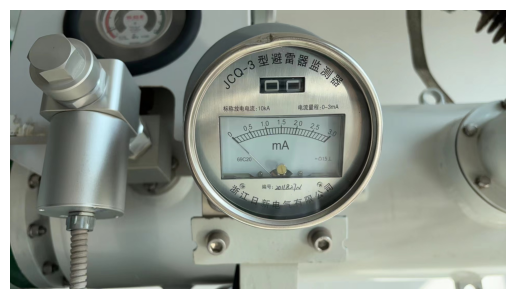

In [50]:
print(image.shape)
show_img(image)

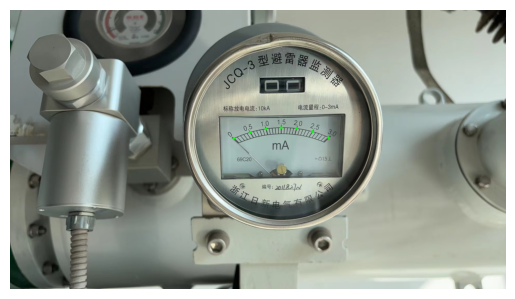

In [51]:
# candidate_point = [
#     (137,337), (121,183), (262,102), (396,195), (359,355)
# ]

candidate_point = [
    (866,497), (929,473), (990,460), (1050,455), (1109,458), (1171,470), (1233,494)
]

image_with_candidate_point = image.copy()
# 在图像上绘制点
for point in candidate_point:
    cv2.circle(image_with_candidate_point, point, 5, (0, 255, 0), -1)  # 绘制绿色实心圆

show_img(image_with_candidate_point)

### 椭圆拟合

In [52]:
def my_fun(parameters, x_samples, y_samples):
    # Unpack parameters: two focus points and the target distance sum
    x_focus_1, y_focus_1, x_focus_2, y_focus_2, sum_of_target_distance = parameters
    
    # Calculate the actual distances from the points to the two foci
    sum_of_actual_distance = (
        np.sqrt((x_samples - x_focus_1) ** 2 + (y_samples - y_focus_1) ** 2) +
        np.sqrt((x_samples - x_focus_2) ** 2 + (y_samples - y_focus_2) ** 2)
    )
    
    # Return the variance of the difference between actual and target distances
    return np.sum(((sum_of_actual_distance - sum_of_target_distance) ** 2) / (len(x_samples) - 1))

In [53]:
def fit_ellipse(x_samples, y_samples):


    # Optimize to fit the ellipse using initial guesses for the parameters
    initial_guess = np.array([np.mean(x_samples), np.mean(y_samples), np.mean(x_samples), np.mean(y_samples), 100])  # Initial focus points and target distance
    res_optimized = so.minimize(fun=my_fun, x0=initial_guess, args=(x_samples, y_samples))
    
    if res_optimized.success:
        # Unpack optimized parameters
        x1_res, y1_res, x2_res, y2_res, l2_res = res_optimized.x
        
        # Calculate the angle of the ellipse based on the foci
        alpha_res = np.arctan2(y2_res - y1_res, x2_res - x1_res)
        
        # Calculate the distance between the foci
        l_ab = np.sqrt((y2_res - y1_res) ** 2 + (x2_res - x1_res) ** 2)
        
        # Calculate semi-major and semi-minor axes
        a_res = l2_res / 2  # Semi-major axis length
        b_res = np.sqrt((l2_res / 2) ** 2 - (l_ab / 2) ** 2)  # Semi-minor axis length


        return a_res, b_res, (x1_res+x2_res)/2, (y1_res+y2_res)/2, alpha_res
    else:

        print('Fail to fit ellipse')
        return None
        # # Generate points on the ellipse
        # theta_res = np.linspace(0.0, 2 * np.pi, 100)  # Angle values
        # x_res = a_res * np.cos(theta_res) * np.cos(alpha_res) - b_res * np.sin(theta_res) * np.sin(alpha_res) + (x1_res+x2_res)/2
        # y_res = b_res * np.sin(theta_res) * np.cos(alpha_res) + a_res * np.cos(theta_res) * np.sin(alpha_res) + (y1_res+y2_res)/2


In [54]:
x_samples = np.array([point[0] for point in candidate_point], dtype=float)
y_samples = np.array([point[1] for point in candidate_point], dtype=float)

# Fit the ellipse to the generated samples
a_res, b_res, x0, y0, alpha_res = fit_ellipse(x_samples, y_samples)

In [55]:

def get_Point_in_ellipse(h, k, a, b, alpha, theta):
    x = h + a * np.cos(alpha) * np.cos(theta) - b * np.sin(alpha) * np.sin(theta)
    y = k + a * np.cos(alpha) * np.sin(theta) + b * np.sin(alpha) * np.cos(theta)
    return x, y
# '''
# 当椭圆不仅需要平移，而且其长轴和短轴不与坐标轴平行时\会稍微复杂一些。此时，除了平移之外，还需要考虑旋转。假设椭圆中心位于点 \((h, k)\)，并且椭圆绕其中心旋转了一个角度 \(\theta\)（逆时针方向），那么椭圆的参数方程可以表示为：

# \[ x = h + a \cos(t) \cos(\theta) - b \sin(t) \sin(\theta) \]
# \[ y = k + a \cos(t) \sin(\theta) + b \sin(t) \cos(\theta) \]

# 这里：
# - \(a\) 是椭圆的半长轴。
# - \(b\) 是椭圆的半短轴。
# - \(t\) 是参数，通常取值范围是从 \(0\) 到 \(2\pi\)。
# - \((h, k)\) 是椭圆中心的坐标。
# - \(\theta\) 是椭圆长轴与正x轴之间的夹角。

# 这个方程组描述了如何通过平移和旋转来定位椭圆上的任何一点。旋转的角度 \(\theta\) 决定了椭圆的方向，而 \(h\) 和 \(k\) 决定了椭圆的位置。
# '''

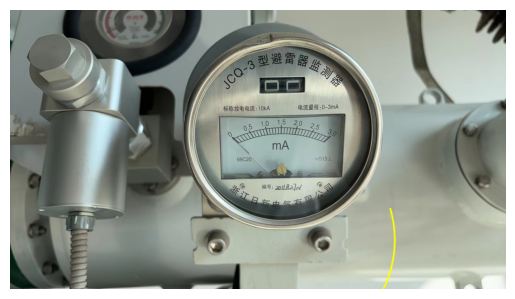

In [60]:
theta_res = np.linspace(-np.pi/2, -np.pi, 100)  # Angle values
x_res, y_res = get_Point_in_ellipse(x0, y0, a_res, b_res, alpha_res, theta_res)

image_with_ellipse_point = image.copy()
for (x, y) in zip(x_res, y_res):
    cv2.circle(image_with_ellipse_point, (int(x), int(y)), 4, (0, 255, 255), -1)  # 绘制绿色实心圆

show_img(image_with_ellipse_point)

## 计算刻度点坐标

In [57]:
# np.arctan2(y,x) 使用arctan2求弧度制夹角
# 第一象限 0 -> pi （逆时针）
# 第二象限 pi -> 2pi
# 第三象限 -2pi -> -pi
# 第四象限 -pi -> 0

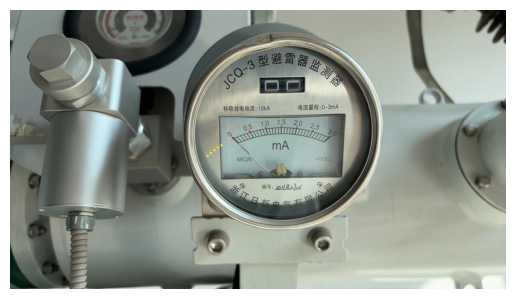

In [71]:
samples_num = len(x_samples)
SMALL_POINT = 5

for i in range(1, samples_num):
    
    s_point_x, s_point_y = x_samples[i - 1], y_samples[i - 1]
    t_point_x, t_point_y = x_samples[i], y_samples[i]
    
    # 两个相邻标点不应该超过90度
    theta_s = np.arctan2(-(s_point_y - y0), -(s_point_x - x0))
    theta_t = np.arctan2(-(t_point_y - y0), -(t_point_x - x0))
    if theta_s > theta_t: theta_s += np.pi * 2
     
    theta_small_point = np.linspace(theta_s, theta_t, SMALL_POINT)
    x_small, y_small = get_Point_in_ellipse(x0, y0, a_res, b_res, alpha_res, theta_small_point)
    
    image_with_ellipse_point = image.copy()
    for (x, y) in zip(x_small, y_small):
        cv2.circle(image_with_ellipse_point, (int(x), int(y)), 4, (0, 255, 255), -1)  # 绘制绿色实心圆

    cv2.circle(image_with_ellipse_point, (int(x_samples[i-1]), int(y_samples[i-1])), 4, (0, 0, 255), -1)  # 绘制绿色实心圆
    cv2.circle(image_with_ellipse_point, (int(x_samples[i]), int(y_samples[i])), 4, (0, 0, 255), -1)  # 绘制绿色实心圆
    show_img(image_with_ellipse_point)
    break
      

In [62]:
x_samples[0], y_samples[0]

(np.float64(866.0), np.float64(497.0))